# Credit Card Default Prediction
___

DSCI 100 - Group 154: Eric Pien, Sydney Quach, Aryan Taneja, Kaila Villarey

## Introduction
___

#### **Background** ####
Credit Cards are an essential part of our daily lives today. Per Statista there were 76M credit cards in circulation within Canada. Also, credit card loan securitization is a huge business for banks and asset managers. As such, a large-scale default could lead to systemic failures of banks and the broader capital markets as observed in GFC.

#### **Thesis** ####
Using the data and the techniques learned in class, we would like to answer the question: **can we predict the default status of a credit card client?**

#### **Data** ####
The data is from a debit and credit card issuing bank in Taiwan. The data consists of information about 30,000 customers as at October 2005, of which 23,364 (78%) have not defaulted while 6,636 (22%) have defaulted. The default status is represented as a binary variable (1 = Yes, 0 = No). 

Variables available to be used as direct inputs are as below:
* **X1**: Amount of Credit Given (NT\$)
* **X2**: Sex (1 = Male, 2 = Female)
* **X3**: Education (1 = Graduate School, 2 = University, 3 = High School, 4 = Others)
* **X4**: Marital Status (1 = Married, 2 = Single, 3 = Others)
* **X5**: Age (# of Years)
* **X6-X11**: Repayment Status (-1 = Clear, 1 = Payment Delay of 1 Month, 2 = Payment Delay of 2 Months, ..., 8 = Payment Delay of 8 Months, 9 = Payment Delay of 9 Months or greater)
    * **X6-11**  = 2005-09 to 2005-04
* **X12-X17**: Amount of Bill Statement (NT\$)
    * **X12-17** = 2005-09 to 2005-04
* **X18-X23**: Amount of Previous Payment (NT\$)
    * **X18-23** = 2005-09 to 2005-04

Source of Data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## Preliminary Exploratory Data Analysis
___

In [27]:
# Environment Setup

library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)

### Data Loading, Cleaning, Splitting ###
____

In [28]:
# Specify column names to make it easier to work with
columns = c('id', 'credit_limit', 'sex', 'education', 'marital_status', 'age',
            'status_09', 'status_08', 'status_07', 'status_06', 'status_05', 'status_04',
            'balance_09', 'balance_08', 'balance_07', 'balance_06', 'balance_05', 'balance_04',
            'payment_09', 'payment_08', 'payment_07', 'payment_06', 'payment_05', 'payment_04',
            'y')
            
# Read from the web into R
credit_card_data <- read_csv('https://raw.githubusercontent.com/ericpien/dsci-100-group-154/main/data/default%20of%20credit%20card%20clients.csv',skip=2,col_names=columns) |>
    select(-id)

# Clead Data and rid of any non-defined observations
credit_card_data <- credit_card_data |>
    mutate(status_09 = status_09+1,
        status_08 = status_08+1,
        status_07 = status_07+1,
        status_06 = status_06+1,
        status_05 = status_05+1,
        status_04 = status_04+1) |>
    filter(marital_status %in% c(1,2,3)) |>
    filter(sex %in% c(1,2)) |>
    filter(education %in% c(1,2,3,4))

# Check for NA Data
na_data_count <- sapply(credit_card_data,function(x) sum(is.na(x))) |>
    t() |>
    as_tibble()
    
na_data_count

# Check the data is pre-loaded in tidy format
head(credit_card_data)

# Split betwween training and testing data
set.seed(154)
credit_card_split <- credit_card_data |> initial_split(prop=0.75, strata = y)
credit_card_train <- training(credit_card_split)
credit_card_test <- testing(credit_card_split)

Rows: 30000 Columns: 25
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (25): id, credit_limit, sex, education, marital_status, age, status_09, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20000,2,2,1,24,3,3,0,0,-1,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,0,3,1,1,1,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,1,1,1,1,1,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,1,1,1,1,1,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,0,1,0,1,1,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,1,1,1,1,1,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


### Summary Tables ###
____

### Summary of Categorical Columns ###

In [29]:
# Summarize the data - count and average demographic profile of clients by default and non-default status

credit_card_train |>
    group_by(y) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

y,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
0,17247,35.39015,178142.6,52382.82
1,4953,35.64527,131515.8,47883.55


In [30]:
# Summarize the data - count and average demographic profile of clients by sex

credit_card_train |>
    group_by(sex) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

sex,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,8808,36.48899,164417.3,54876.21
2,13392,34.76180,169925.0,49078.85


In [31]:
# Summarize the data - count and average demographic profile of clients by education

credit_card_train |>
    group_by(education) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

education,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7885,34.20812,213247.9,49532.46
2,10604,34.72105,147226.1,53711.06
3,3624,40.30298,127339.3,48303.86
4,87,33.95402,226436.8,62585.16


In [32]:
# Summarize the data - count and average demographic profile of clients by marital status

credit_card_train |>
    group_by(marital_status) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

marital_status,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,10119,39.96680,183160.98,53308.12
2,11834,31.42488,156069.60,49915.76
3,247,42.99190,95101.21,42452.24


In [33]:
# Summarize the data - count and average demographic profile of clients by payment status

credit_card_train |>
    group_by(status_09) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

status_09,count,average_age,average_credit_limit,average_balance_09
<dbl>,<int>,<dbl>,<dbl>,<dbl>
-1,2034,36.98722,250255.65,8443.311
0,4147,36.19918,208314.44,10451.482
1,10980,34.91867,154285.76,78091.323
2,2752,35.34121,149138.81,27651.698
3,1947,35.36466,111543.91,65841.426
4,233,35.42918,85021.46,39023.399
5,57,35.24561,78771.93,67193.930
6,18,35.11111,84444.44,100966.444
7,9,36.11111,84444.44,85770.778


### Summary of Numericial Columns ###

In [34]:
# Summarize the data - Min, Mean, Median, and Max of the numerical columns by default status (y)

numeric_cols_train <- credit_card_train |>
    select(-sex, -education, -marital_status, -status_09, -status_08, -status_07, -status_06, -status_05, -status_04)

min_0 <- apply(filter(numeric_cols_train, y == 0), 2, min, na.rm = TRUE)
average_0 <- apply(filter(numeric_cols_train, y == 0), 2, mean, na.rm = TRUE)
median_0 <- apply(filter(numeric_cols_train, y == 0), 2, median, na.rm = TRUE)
max_0 <- apply(filter(numeric_cols_train, y == 0), 2, max, na.rm = TRUE)
min_1 <- apply(filter(numeric_cols_train, y == 1), 2, min, na.rm = TRUE)
average_1 <- apply(filter(numeric_cols_train, y == 1), 2, mean, na.rm = TRUE)
median_1 <- apply(filter(numeric_cols_train, y == 1), 2, median, na.rm = TRUE)
max_1 <- apply(filter(numeric_cols_train, y == 1), 2, max, na.rm = TRUE)

numeric_cols_summary <- rbind(min_0, average_0, median_0, max_0, min_1, average_1, median_1, max_1) |>
    as_tibble() |>
    mutate(info = c('Min','Mean','Median','Max','Min','Mean','Median','Max')) |>
    relocate(y,.before=credit_limit) |>
    relocate(info,.before=credit_limit)

numeric_cols_summary

y,info,credit_limit,age,balance_09,balance_08,balance_07,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Min,10000.0,21.00000,-15308.00,-67526.00,-157264.00,-170000.00,-81334.00,-209051.00,0.000,0.000,0.000,0.000,0.000,0.000
0,Mean,178142.6,35.39015,52382.82,50110.76,47903.33,43961.13,40994.48,39694.07,6353.887,6655.716,5732.676,5285.201,5255.274,5690.534
0,Median,150000.0,34.00000,23900.00,22441.00,20694.00,19262.00,18258.00,17159.00,2500.000,2253.000,2000.000,1786.000,1829.000,1740.000
0,Max,1000000.0,79.00000,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.000,1684259.000,896040.000,621000.000,426529.000,528666.000
1,Min,10000.0,21.00000,-6029.00,-9119.00,-61506.00,-65167.00,-53007.00,-339603.00,0.000,0.000,0.000,0.000,0.000,0.000
1,Mean,131515.8,35.64527,47883.55,46779.31,44618.47,41600.41,39327.82,38206.65,3447.671,3405.968,3284.918,3089.582,3345.432,3568.310
1,Median,90000.0,34.00000,20214.00,20358.00,19783.00,19068.00,18283.00,17932.00,1633.000,1514.000,1200.000,1000.000,1000.000,1000.000
1,Max,740000.0,73.00000,613860.00,581775.00,572677.00,541019.00,547880.00,498316.00,300000.000,358689.000,234456.000,432130.000,332000.000,345293.000


### Visualization ###
____

`summarise()` has grouped output by 'sex', 'education'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'sex', 'marital_status'. You can override
using the `.groups` argument.


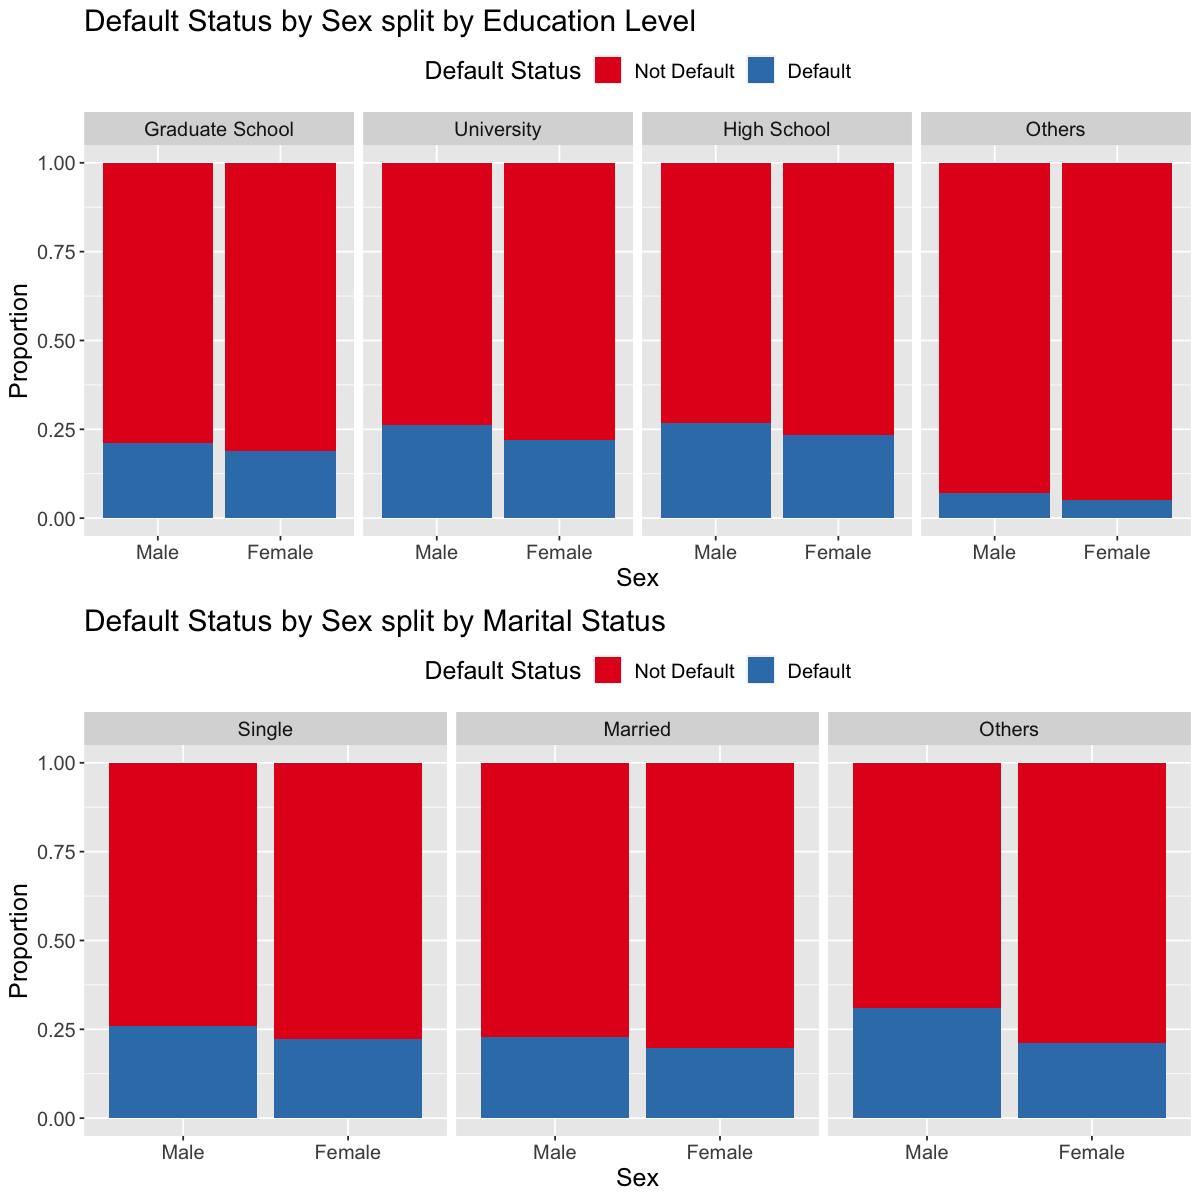

In [35]:
# Proportion of Default Status by Sex split by Education level and Marital Status

options(repr.plot.width = 10, repr.plot.height = 10) 

default_vs_sex_edu <- credit_card_train |>
    group_by(sex, education, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ education,ncol=4, labeller = labeller(
        education = c("1" = "Graduate School", "2" = "University", "3" = "High School", "4" = "Others"))) +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Education Level") +
    theme(text = element_text(size=15),legend.position = "top")

default_vs_sex_mar <- credit_card_train |>
    group_by(sex, marital_status, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ marital_status,ncol=4, labeller = labeller(
        marital_status = c("1" = "Single", "2" = "Married", "3" = "Others"))) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Marital Status") +
    theme(text = element_text(size=15),legend.position = "top")

grid.arrange(default_vs_sex_edu,default_vs_sex_mar)

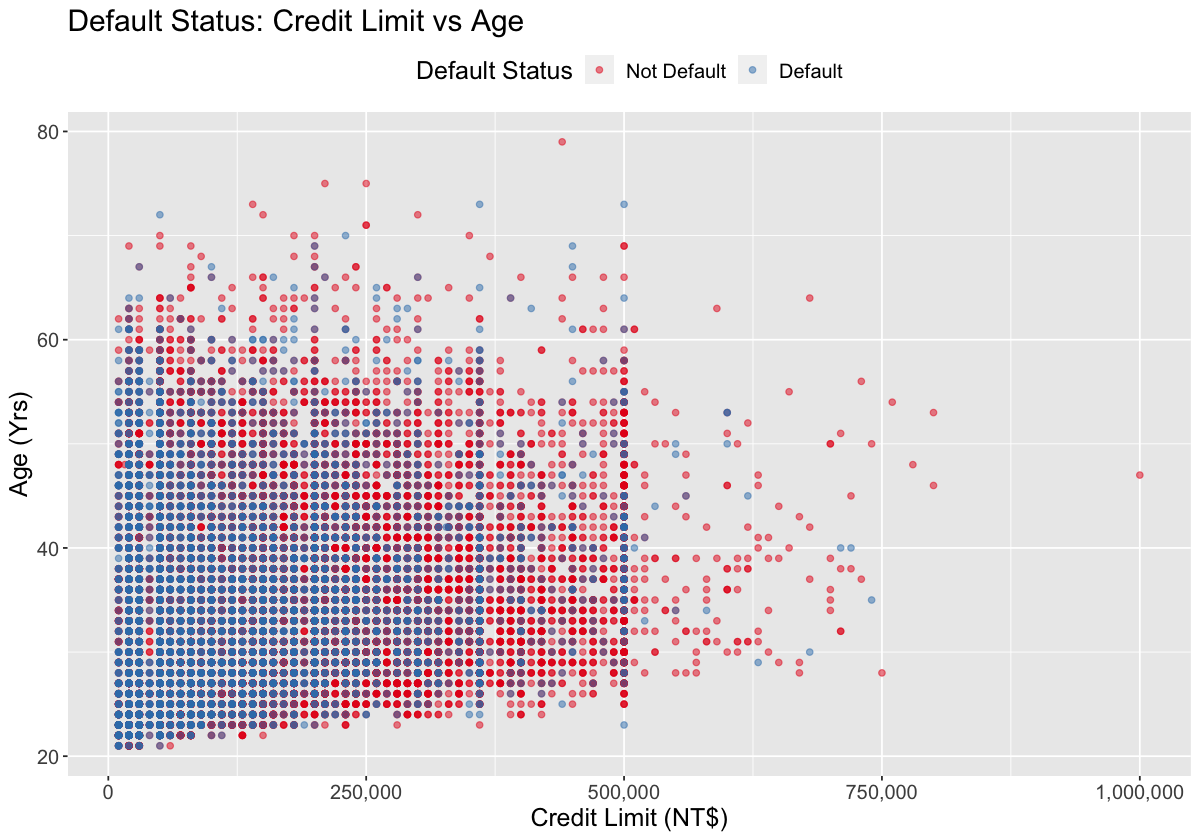

In [36]:
# Scatterplot of default status by credit limit and age

options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_credit_limit <- credit_card_train |>
    ggplot(aes(x=credit_limit,y=age, color=as_factor(y))) +
    geom_point(alpha=0.5) +
    scale_color_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="Credit Limit (NT$)"
        , y="Age (Yrs)"
        , color = "Default Status"
        , title= "Default Status: Credit Limit vs Age") +
    theme(text = element_text(size=15),legend.position = "top")

age_vs_credit_limit

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



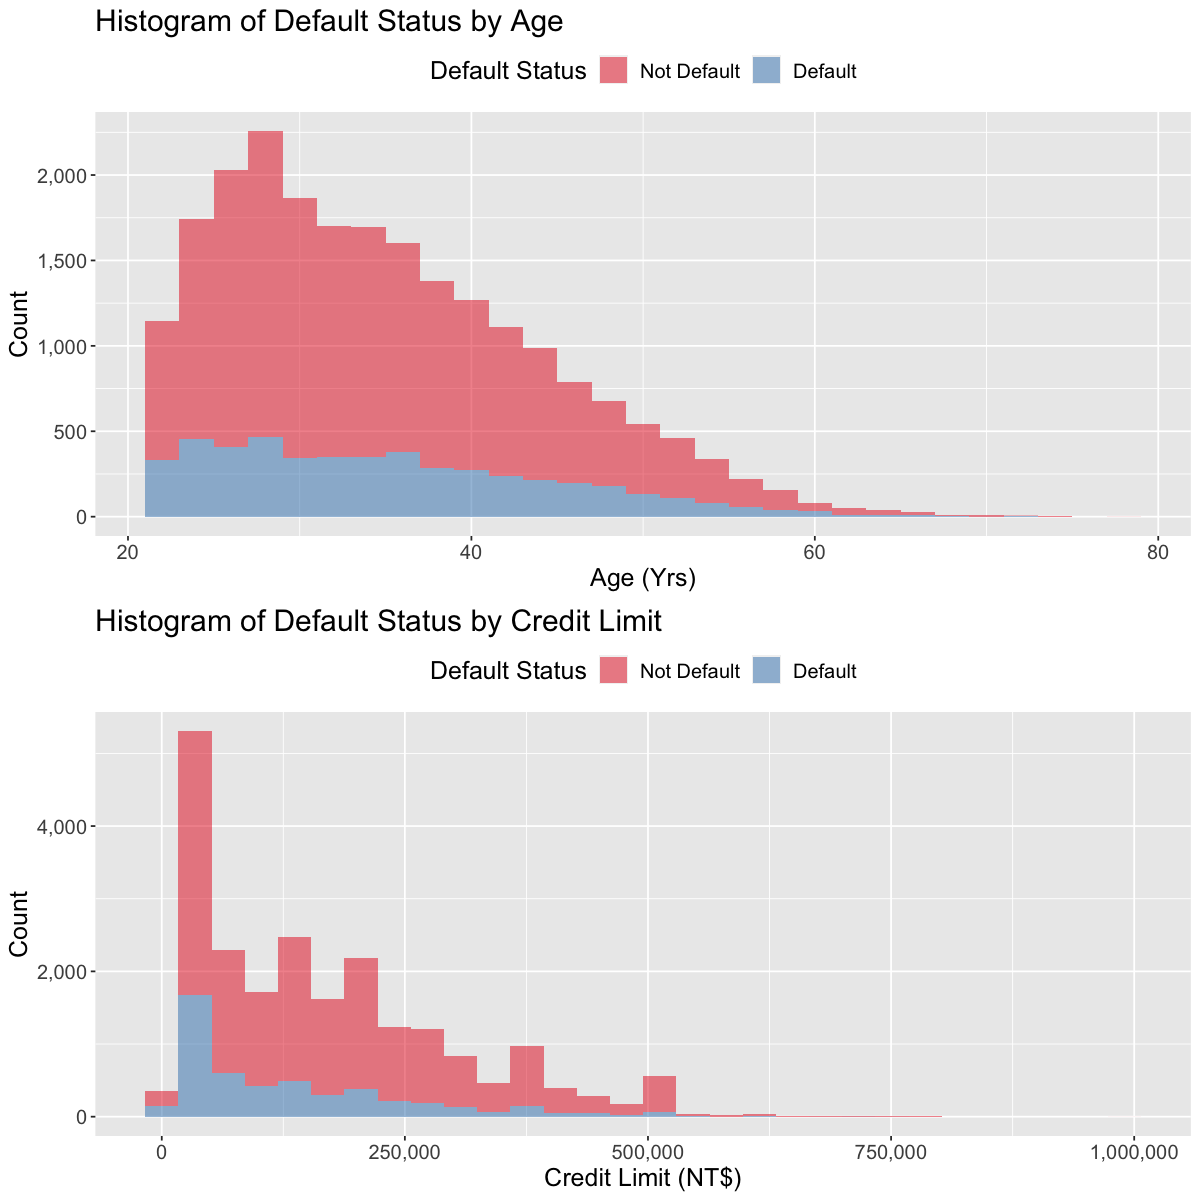

In [37]:
# Histogram of default status by credit limit and age

options(repr.plot.width = 10, repr.plot.height = 10) 

density_plot_age <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=age, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Age (Yrs)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Age")+
    theme(text = element_text(size=15),legend.position = "top")


density_plot_credit_limit <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=credit_limit, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Credit Limit (NT$)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Credit Limit")+
    theme(text = element_text(size=15),legend.position = "top")

grid.arrange(density_plot_age,density_plot_credit_limit)

## Methods
___

* As a first step, we will look to enhance the available input variables through feature engineering.
    * For instance, payment history should be reviewed in proportion to each person's outstanding credit balance. This could take the form of:
        ```r
            ... <- ... |> 
                mutate(debt_paid_pct_n = payment_n / balance_n)
        ```
    * In addition, we can explore ways to contextualize the momentum of payments. A reasonable place to start there may be asking - does increasing pace of payment month over month imply lower likelihood of defaulting? Such variable could be proxied as such:
        ```r
            ... <- ... |> 
                mutate(momentum_n = payment_n / payment_m -1)
        ```
    * Another factor could be the level of financial stress as proxied by the outstanding debt over the available balance. This could take the form of:
        ```r
            ... <- ... |>
                mutate(pct_credit_used_n = balance_n / credit_limit)
        ```

* We will then select variables that most likely explain a person's default status. For instance, payment from 5 months ago is less likely to have significant explanatory power over that of last months' payment. Using these variables, we will use classification model to predict the default status of the clients in the testing set.
* After training the model and producing the predicted output, we will visualize the results in several ways. Below are just examples:
    1. Comparison between $Y$ and $\hat{Y}$ using scatterplot
    2. Comparison by demographic profile to see if the model is able to better predict within certain class

## Expected Outcomes and Significance
___

**We expect to find varying degrees of relationship between default status and direct categorical variables.**
1. Positive relationship between default status vs education. 
2. No relationship between default status vs age, sex, and marital status.

**The findings could have a broad positive impact. Specifically, it could:**
1. Create a less risky credit environment for both banks and credit card users
2. Develop educational programs for people at higher risk to minimize chance of systemic credit defaults.

**This could lead us to future questions like:**
1. What role does employment play in the default status of a credit card?